In [16]:
# External library imports for image processing and manipulation
import cv2
import matplotlib.pyplot as plt
import numpy as np

# PyTorch related imports
import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import IterableDataset

import scribbles
import visualize

In [7]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118



Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.2/819.2 MB 3.3 MB/s eta 0:00:0000:0100:05
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.17.1%2Bcu118-cp310-cp310-linux_x86_64.whl (6.2 MB)
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.2.1%2Bcu118-cp310-cp310-linux_x86_64.whl (3.3 MB)
  Using cached https://download.pytorch.org/whl/Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached https://download.pytorch.org/whl/cu118/nvidia_cuda_nvrtc_cu11-11.8.89-py3-none-manylinux1_x86_64.whl (23.2 MB)
  Using cached https://download.pytorch.org/whl/cu118/nvidia_cuda_runtime_cu11-11.8.89-py3-none-manylinux1_x86_64.whl (875 kB)
  Using cached https://download.pytorch.org/whl/cu118/nvidia_cuda_cupti_cu11-11.8.87-py3-none-manylinux1_x86_64.whl (13.1 MB)
  Using cached https://download.pytorch.org/whl/cu118/nvidia_cudnn_cu11-8.7.0.84-py3-none-manylinux1_x86_64.whl (728.5 MB)
  Using cached https://do

In [9]:
#Load RbG image
file_path = '2023-12-25_10_26.jpg' 
rgb_image = cv2.imread(file_path, cv2.IMREAD_COLOR)
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

#Loag Mask
file_path = '2023-12-25_10_26.png' 
gray_image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

In [10]:
# Define your parameters here
border_scribble_max_chunk_length = 200
border_scribble_min_chunk_length = 10
border_scribble_border_margin = 5
border_scribble_epsilon = 2
border_scribble_thicknes = 3
border_scribble_inclusion_probability = 1
border_scribble_erode_iterations = 0

# Generate scribbles for all classes
border_sribbles = scribbles.generate_border_multiclass_scribbles(gray_image, border_scribble_max_chunk_length, border_scribble_min_chunk_length, border_scribble_border_margin, border_scribble_epsilon, border_scribble_inclusion_probability, border_scribble_thicknes,border_scribble_erode_iterations)

# Now scribbles_image will contain the scribbles where the pixel values correspond to the class labels

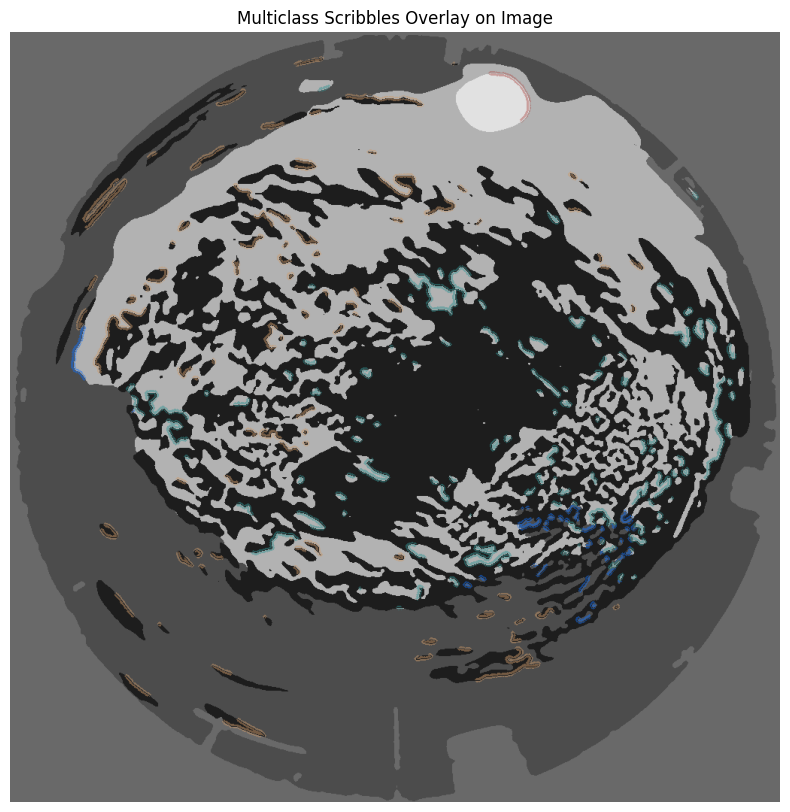

In [11]:
# Plot the overlayed multiclass scribbles on the grayscale image, works with etier the mask or the RGB
visualize.plot_overlay_multiclass_scribbles(gray_image, border_sribbles,plot_size=(10,10))

In [12]:
# Define parameters
intern_scribble_num_scribbles_per_contour = 1  
intern_scribble_max_scribble_length = 30        
intern_scribble_thickness_range = (2, 5)       
intern_scribble_scribble_density=0.01
intern_scribble_edge_thickness = 10
 # Maximum length of each small scribble

# Generate internal scribbles
internal_scribbles = scribbles.generate_scribbles_inside_contours(gray_image, intern_scribble_num_scribbles_per_contour, intern_scribble_max_scribble_length, intern_scribble_thickness_range, intern_scribble_edge_thickness)


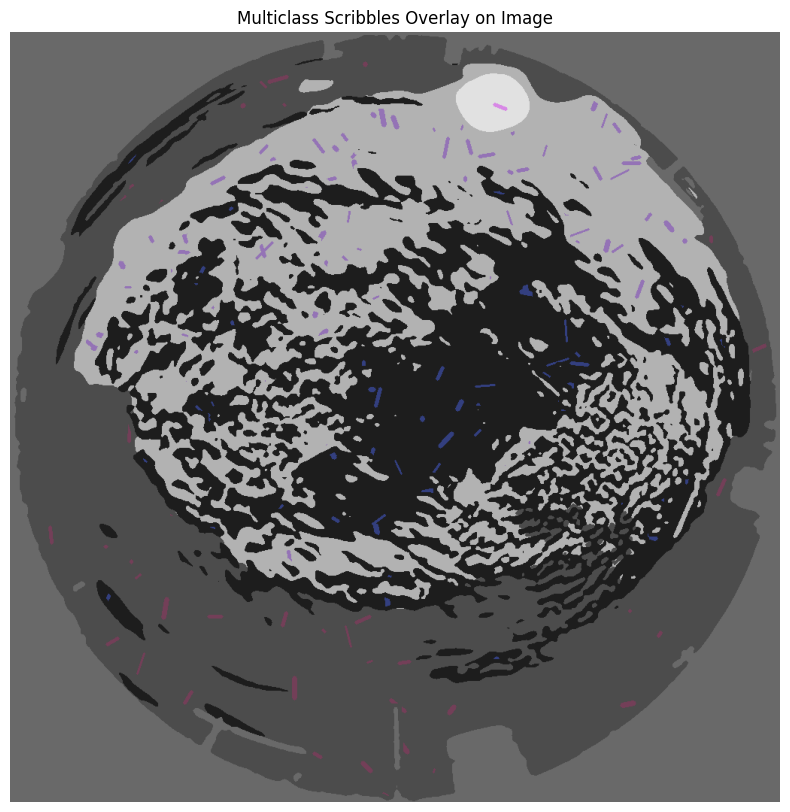

In [13]:
visualize.plot_overlay_multiclass_scribbles(gray_image, internal_scribbles,plot_size=(10,10))

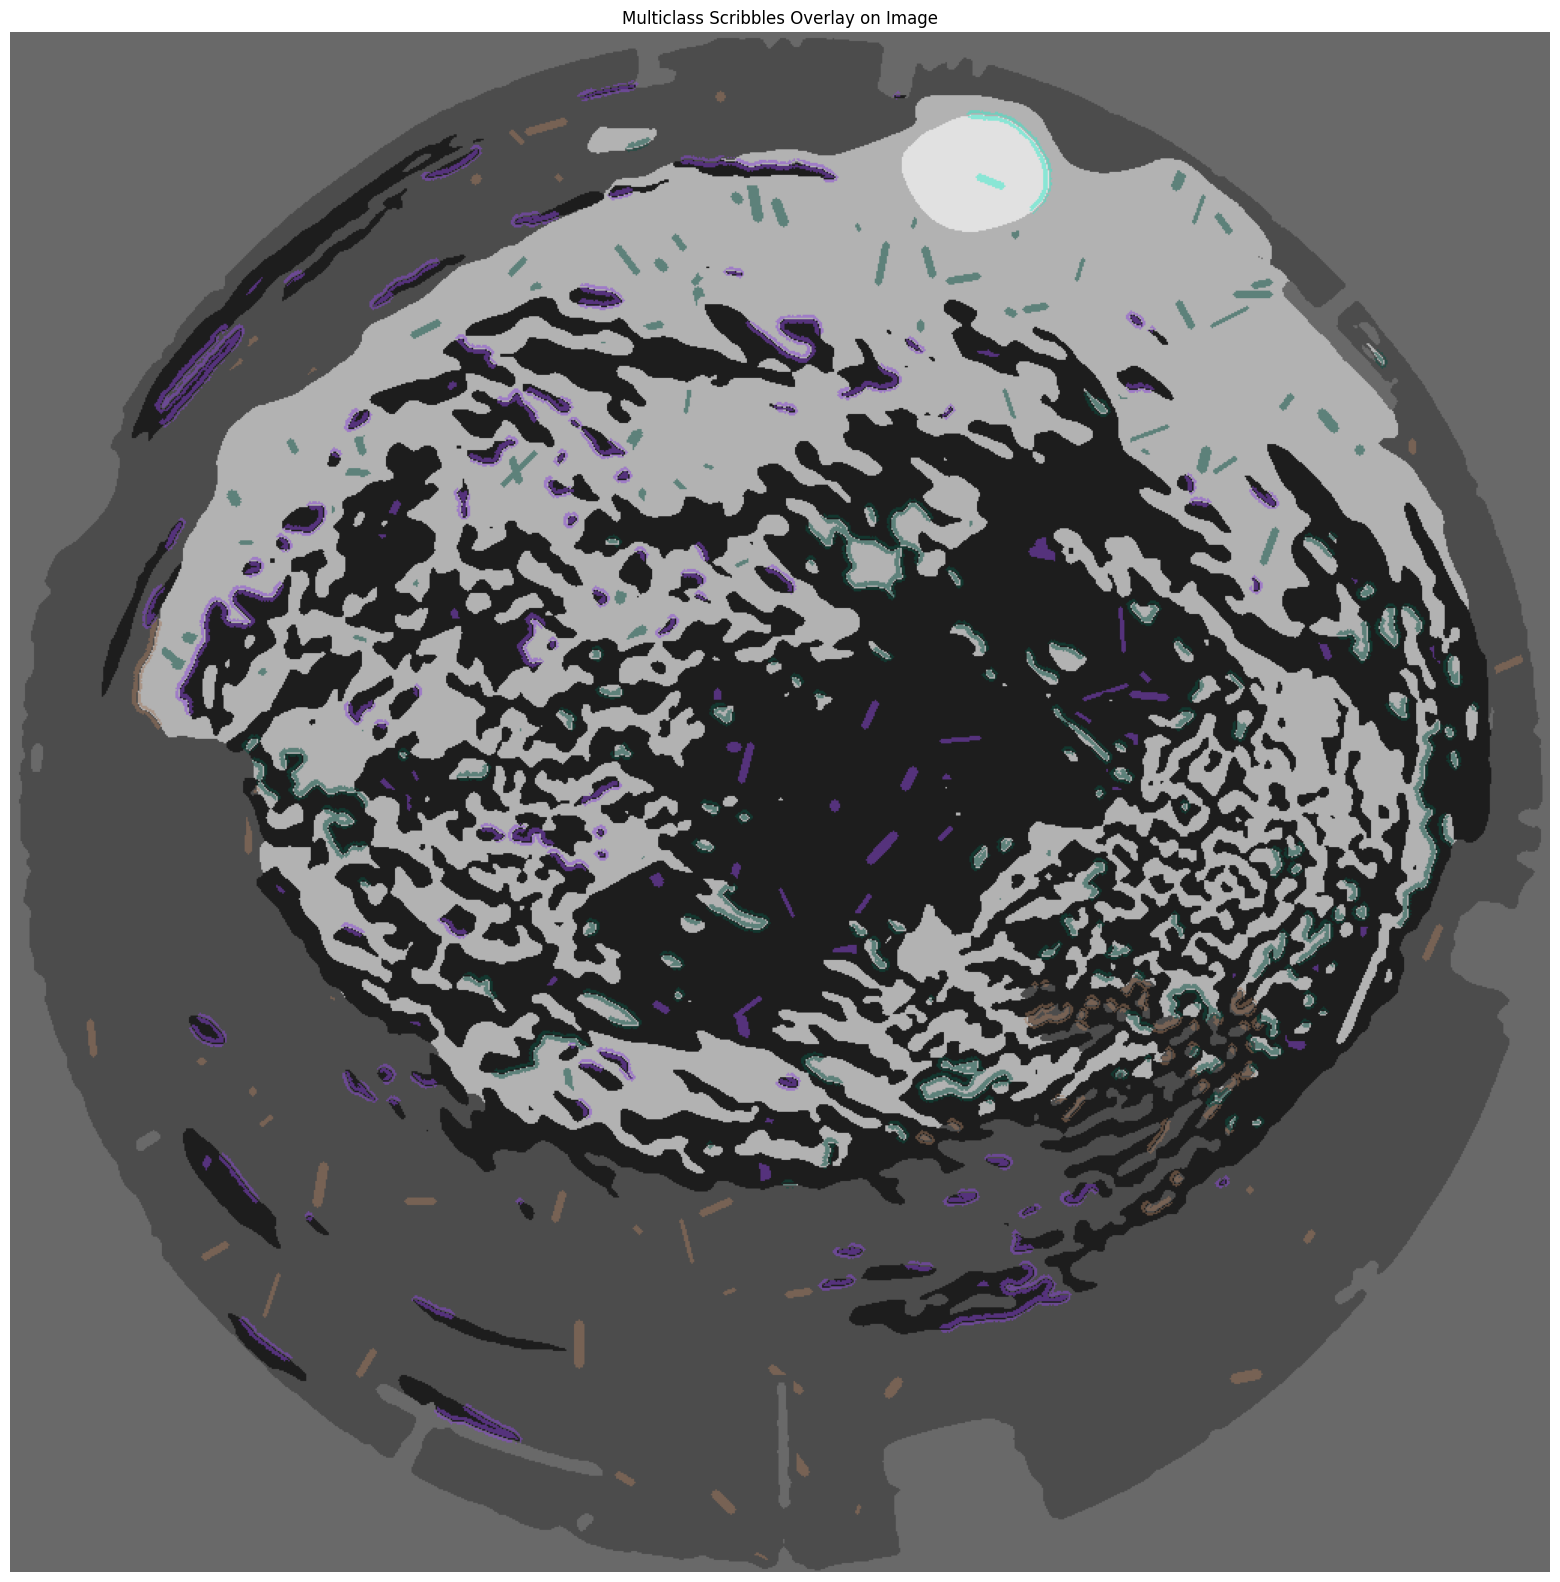

In [14]:
combined_scribbles = np.maximum(border_sribbles, internal_scribbles)
visualize.plot_overlay_multiclass_scribbles(gray_image, combined_scribbles)

In [17]:
class CustomScribbleDataset(IterableDataset):
    def __init__(self, image_paths, mask_paths, n_binary, n_subclasses, border_scribble_params, internal_scribble_params):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.n_binary = n_binary
        self.n_subclasses = n_subclasses
        self.border_scribble_params = border_scribble_params
        self.internal_scribble_params = internal_scribble_params
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __iter__(self):
        for idx in range(len(self.image_paths)):
            # Load image and mask
            image = cv2.imread(self.image_paths[idx], cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

            # Normalize and convert the image to tensor
            image_tensor = transforms.ToTensor()(image)
            image_tensor = self.normalize(image_tensor)

            unique_classes = np.unique(mask)
            unique_classes = unique_classes[unique_classes != 0]
            
            # Binary classification for random classes
            if self.n_binary > 0 and len(unique_classes) > 1:
                for _ in range(self.n_binary):
                    cls = np.random.choice(unique_classes)
                    binary_mask = np.where(mask == cls, cls, 0)
                    print(np.unique(binary_mask))
                    binary_mask_tensor = torch.tensor(binary_mask, dtype=torch.float32).unsqueeze(0)
                    scribble_mask_tensor = self._generate_scribble_mask(binary_mask_tensor)
                    yield image_tensor, scribble_mask_tensor,binary_mask_tensor
            
            # Generate multiclass scenarios
            if self.n_subclasses > 0 and len(unique_classes) > 1:
                n_subclasses = len(unique_classes) if len(unique_classes) <= self.n_subclasses else self.n_subclasses
                for _ in range(self.n_subclasses):
                    num_classes = np.random.randint(2, len(unique_classes))
                    selected_classes = np.random.choice(unique_classes, num_classes, replace=False)
                    print(selected_classes)

                    # Create a multiclass mask with original class labels
                    sub_mask = np.zeros_like(mask)
                    for cls in selected_classes:
                        sub_mask[mask == cls] = cls

                    sub_mask_tensor = torch.tensor(sub_mask, dtype=torch.int64).unsqueeze(0)
                    scribble_mask_tensor = self._generate_scribble_mask(sub_mask_tensor)
                    yield image_tensor, scribble_mask_tensor, sub_mask_tensor

    def _generate_scribble_mask(self, mask_tensor):
        # Convert tensor to numpy array and remove channel dimension
        mask = mask_tensor.squeeze().numpy().astype(np.uint8)

        # Generate scribbles inside contours
        internal_scribbles = scribbles.generate_scribbles_inside_contours(mask, **self.internal_scribble_params)

        # Generate border scribbles
        border_scribbles = scribbles.generate_border_multiclass_scribbles(mask, **self.border_scribble_params)

        # Combine scribbles
        combined_scribbles = np.maximum(internal_scribbles, border_scribbles)

        # Convert combined scribbles to tensor
        scribble_tensor = torch.tensor(combined_scribbles, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        return scribble_tensor

In [19]:
# Usage
image_paths = ['2023-12-25_10_26.jpg']
mask_paths = ['2023-12-25_10_26.png' ]
border_scribble_params = {
    'border_scribble_max_chunk_length': 200,
    'border_scribble_min_chunk_length': 10,
    'border_scribble_border_margin': 5,
    'border_scribble_epsilon': 2,
    'border_scribble_thickness': 3,
    'border_scribble_inclusion_probability': 1,
    'border_scribble_erode_iterations': 0,
}

internal_scribble_params = {
    'intern_scribble_num_scribbles_per_contour': 1,
    'intern_scribble_max_scribble_length': 30,
    'intern_scribble_thickness_range': (2, 5),
    #'intern_scribble_scribble_density': 0.01,
    'intern_scribble_edge_thickness': 10
}

n_subclasses = 4  # Number of random subclasses to select
n_binary = 4

dataset = CustomScribbleDataset(image_paths, mask_paths, n_binary, n_subclasses, border_scribble_params, internal_scribble_params)

scenarios = []
for scenario in dataset:
    scenarios.append(scenario)

[ 0 76]
[ 0 29]
[  0 105]
[  0 225]
[225  29 105]
[ 76 178  29]
[ 76 225]
[ 29 178]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


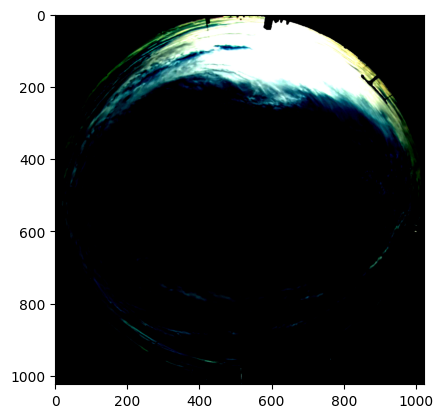

In [20]:
plt.imshow(scenarios[0][0].cpu().numpy().transpose(1,2,0))

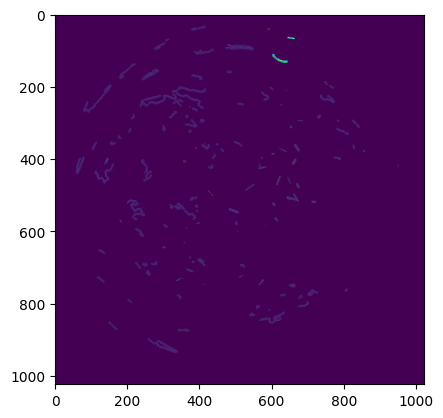

In [21]:
plt.imshow(scenarios[4][1].cpu().numpy().transpose(1,2,0))

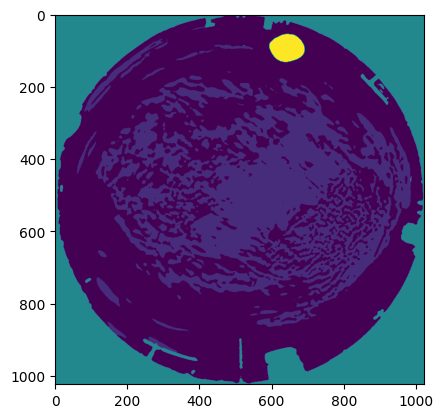

In [22]:
plt.imshow(scenarios[4][2].cpu().numpy().transpose(1,2,0))